In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
from pathlib import Path
# import all samples as dictionary ...
from samples import *

In [4]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

In [5]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-white')
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
from matplotlib.gridspec import GridSpec
import bbi
from cooltools import snipping

In [6]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[autosomal_chroms].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.parse_regions(hg19_arms)
hg19_arms["name"] = [f"{chrom}{arm}" for chrom in autosomal_chroms for arm in list('pq')]
hg19_arms.to_csv("hg19_arms.bed",sep="\t",index=False,header=False)

In [8]:
conditions = ['442-NT','442-IAA']
binsize = 2000
binsize_human = f"{int(binsize/1_000)}kb"

cooler_paths = {    
    '442-NT' : f'CkoCT442-NT-pool.mcool::resolutions/{binsize}',
    '442-IAA' : f'CkoCT442-IAA-pool.mcool::resolutions/{binsize}',
}
long_names = {
    '442-NT' : 'CTCFdegron-442-nontreated-pool',
    '442-IAA': 'CTCFdegron-442-auxin-pool',
}

pal = sns.color_palette('colorblind')
colors = {
    '442-NT': "#e74c3c",
    '442-IAA': pal[2],
}
clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

In [9]:
# iterate over samples to calculate insulation on:
for cond in conditions:
    lname,*_ = cooler_paths[cond].split(".mcool")
    target_exp_file = Path(f"{lname}.{binsize_human}.cis.exp.tsv")
    if target_exp_file.is_file():
        print("already exist !")
        print(target_exp_file)
        continue
    else:
        print("working on ...")
        print(cond,lname)
        ######################################
        !cooltools compute-expected \
            --nproc 4 \
            --output {target_exp_file} \
            --regions hg19_arms.bed \
            --contact-type cis \
            --balance \
            --weight-name weight \
            --ignore-diags 2 \
            {cooler_paths[cond]}
        ######################################


already exist !
CkoCT442-NT-pool.2kb.cis.exp.tsv
already exist !
CkoCT442-IAA-pool.2kb.cis.exp.tsv


In [10]:
expected_paths = {    
    '442-NT' : f'CkoCT442-NT-pool.{binsize_human}.cis.exp.tsv',
    '442-IAA' : f'CkoCT442-IAA-pool.{binsize_human}.cis.exp.tsv',
}
expecteds = {
    cond: pd.read_csv(expected_paths[cond], sep="\t") for cond in conditions
}

In [11]:
# read a BEDPE file with interactions chr1,start1, ...end2 - with optional annotations
# that would enable one to split pileups by category ...
sites = pd.read_table("nearestCTCF_TSS.bedpe", delimiter='\t')
# sites = pd.read_table("allCTCF_TSS.bedpe", delimiter='\t')


sites['mid1'] = (sites['start1'] + sites['end1'])/2
sites['mid2'] = (sites['start2'] + sites['end2'])/2
print(len(sites))
sites.head()

7176


,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,strand2,type2,distance,mid1,mid2
0,chr1,10151,10508,ctcf,-,chr1,29369,29370,-,tss,18861,10329.5,29369.5
1,chr1,762970,762971,tss,+,chr1,804937,805691,+,ctcf,41966,762970.5,805314.0
2,chr1,804937,805691,ctcf,+,chr1,894635,894636,-,tss,88944,805314.0,894635.5
3,chr1,901861,901862,tss,+,chr1,919017,919979,+,ctcf,17155,901861.5,919498.0
4,chr1,919017,919979,ctcf,+,chr1,1004716,1004717,-,tss,84737,919498.0,1004716.5


In [51]:
snippet_flank = 50_000
windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom1'], 
    sites['mid1'],
    flank_bp=snippet_flank)

windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom2'], 
    sites['mid2'],
    flank_bp=snippet_flank)

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, hg19_arms) # function "assign_regions" might move
windows = windows.dropna() # do we need this ?
# let's filter sites here as well ...
arm_sites = sites.loc[windows.index,:].reset_index(drop=True)
windows = windows.reset_index(drop=True)
#
windows.head()

,chrom1,start1,end1,lo1,hi1,chrom2,start2,end2,lo2,hi2,region
0,chr1,-40000,62000,-20,31,chr1,-22000,80000,-11,40,chr1p
1,chr1,712000,814000,356,407,chr1,754000,856000,377,428,chr1p
2,chr1,754000,856000,377,428,chr1,844000,946000,422,473,chr1p
3,chr1,850000,952000,425,476,chr1,868000,970000,434,485,chr1p
4,chr1,868000,970000,434,485,chr1,954000,1056000,477,528,chr1p


In [13]:
# the most time consuming step !!!
stacks = {}
piles = {}
for cond in conditions:
    snipper = snipping.ObsExpSnipper(clrs[cond], expecteds[cond], regions=hg19_arms)
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    stacks[cond] = stack
    # flipping can be done here ...
    piles[cond] = np.nanmean(stack, axis=2)

Text(0.5, 0.98, '50kb flank\nHi-C resolution = 2kb; # of pairs = 3851')

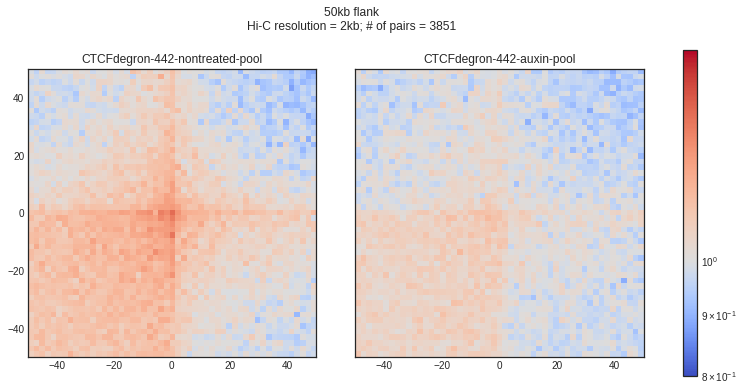

In [69]:
_piles = {}
_mask = (arm_sites["distance"]>50_000) & (arm_sites["distance"]<500_000)
for cond in conditions:
    _substack = stacks[cond][:,:,_mask]
    _piles[cond] = np.nanmean(_substack, axis=2)

gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.8,vmax=1.5,midpoint=1),
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        _piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'{snippet_flank//1000}kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {_mask.sum()}')

### Now we can start subsetting and splitting our `sites` dataframe (table with interactions) into subgroups by annotation
at the end of each subsetting - the goal is to get indices corresponding to the subsetted conditions and extract snippets corresponding to those indices from `stacks[cond]` -> that would be the pileup of the subset of interactions ...

In [81]:
# here is our criteria to select a subgroup of snippets from the stack ....
upstream_pCTCF_pTSS_mask = (arm_sites["type1"]=="ctcf") & \
                        (arm_sites["strand1"]=="+") & \
                        (arm_sites["type2"]=="tss") & \
                        (arm_sites["strand2"]=="+") & \
                        (arm_sites["distance"]>50_000) & \
                        (arm_sites["distance"]<500_000)
#
upstream_pCTCF_pTSS_piles = {}
for cond in conditions:
    # extract only desired snippets from the stack
    # stacks are 3D arrays, with first 2 coords along the heatmap
    # and the last coord (index) is along snippets (individual interactions from BEDPE) ...
    _substack = stacks[cond][:,:,upstream_pCTCF_pTSS_mask]
    upstream_pCTCF_pTSS_piles[cond] = np.nanmean(_substack, axis=2)

Text(0.5, 0.98, '50kb flank\nHi-C resolution = 2kb; # of pairs = 420')

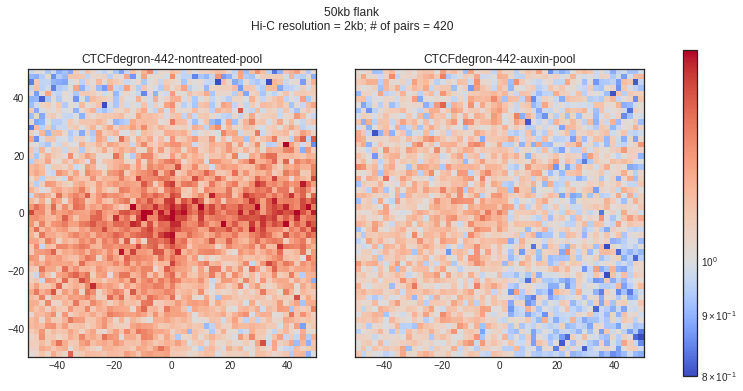

In [82]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.8,vmax=1.5,midpoint=1),
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        upstream_pCTCF_pTSS_piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'{snippet_flank//1000}kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {upstream_pCTCF_pTSS_mask.sum()}')

#### here is the selection we used for _ALL-PAIRWISE_ interactions - right before we turned to neigbours ...

In [36]:
# here is our criteria to select a subgroup of snippets from the stack ....
upstreamCTCF_pTSS_mask = (sites["type1"]=="ctcf") & (sites["type2"]=="tss") & (sites["strand2"]=="+")

upstreamCTCF_pTSS_piles = {}
for cond in conditions:
    # extract only desired snippets from the stack
    # stacks are 3D arrays, with first 2 coords along the heatmap
    # and the last coord (index) is along snippets (individual interactions from BEDPE) ...
    _substack = stacks[cond][:,:,upstreamCTCF_pTSS_mask]
    # flipping can be done here ...
    upstreamCTCF_pTSS_piles[cond] = np.nanmean(_substack, axis=2)

# more conditions to check ...
# (sites["type1"]=="ctcf") & (sites["type2"]=="tss") & (sites["strand2"]=="+")
# (sites["type2"]=="ctcf") & (sites["type1"]=="tss") & (sites["strand1"]=="-")
# (sites["type1"]=="ctcf") & (sites["type2"]=="tss") & (sites["strand2"]=="-")
# (sites["type2"]=="ctcf") & (sites["type1"]=="tss") & (sites["strand1"]=="+")


Text(0.5, 0.98, '50kb flank\nHi-C resolution = 2kb; # of pairs = 11832')

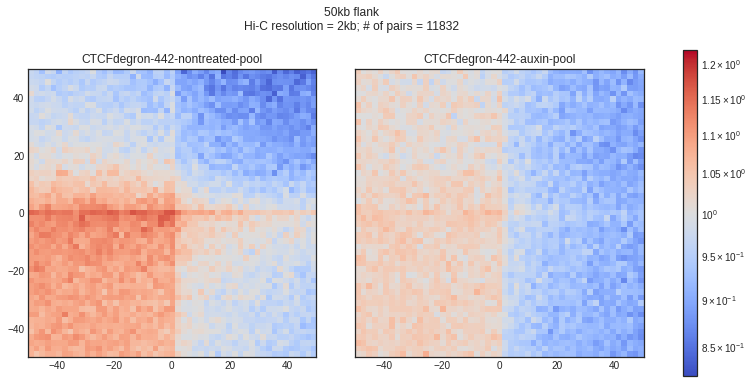

In [35]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.82,vmax=1.22,midpoint=1),
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        upstreamCTCF_pTSS_piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'{snippet_flank//1000}kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {upstreamCTCF_pTSS_mask.sum()}')

### we learned how to flip part of the stackup ...

#### extract stacks for a coupleof relevant conditions that could be combined by flipping - and combine them !!!

In [112]:
# here is our criteria to select a subgroup of snippets from the stack ....
downstream_mCTCF_mTSS_mask = (arm_sites["type1"]=="tss") & \
                        (arm_sites["strand1"]=="-") & \
                        (arm_sites["type2"]=="ctcf") & \
                        (arm_sites["strand2"]=="-") & \
                        (arm_sites["distance"]>50_000) & \
                        (arm_sites["distance"]<500_000)
upstream_pCTCF_pTSS_mask = (arm_sites["type1"]=="ctcf") & \
                        (arm_sites["strand1"]=="+") & \
                        (arm_sites["type2"]=="tss") & \
                        (arm_sites["strand2"]=="+") & \
                        (arm_sites["distance"]>50_000) & \
                        (arm_sites["distance"]<500_000)

# when selecting multiple conditions - it is reasonable to assume
# that these conditions are mutually exclusive
# check that the following way:
print("checking if conditions are mutually exclusive ...")
print(f"number of sites that satisfy either condition: {(upstream_pCTCF_pTSS_mask|downstream_mCTCF_mTSS_mask).sum()} ")
print(f"number of sites that satisfy condition1: {upstream_pCTCF_pTSS_mask.sum()} ")
print(f"number of sites that satisfy condition2: {downstream_mCTCF_mTSS_mask.sum()} ")
print(f"the sum {upstream_pCTCF_pTSS_mask.sum()+downstream_mCTCF_mTSS_mask.sum()} of the two latter ones is supposed to be equal to the former one")


combined_piles = {}
for cond in conditions:
    # extract only desired snippets from the stack
    # stacks are 3D arrays, with first 2 coords along the heatmap
    # and the last coord (index) is along snippets (individual interactions from BEDPE) ...
    _substack1 = stacks[cond][:,:,upstream_pCTCF_pTSS_mask]
    _substack2 = stacks[cond][:,:,downstream_mCTCF_mTSS_mask]
    # try to flip _substack2 !
    # this is going to be specific in each and every case:
    _substack2 = np.rot90(_substack2,1)[:,::-1,:]
    # flipping can be done here ...
    combined_piles[cond] = np.nanmean(
                                np.concatenate([_substack1,_substack2],axis=2),
                                axis=2
                            )

checking if conditions are mutually exclusive ...
number of sites that satisfy either condition: 853 
number of sites that satisfy condition1: 420 
number of sites that satisfy condition2: 433 
the sum 853 of the two latter ones is supposed to be equal to the former one


Text(0.5, 0.98, '50kb flank\nHi-C resolution = 2kb; # of pairs = 853')

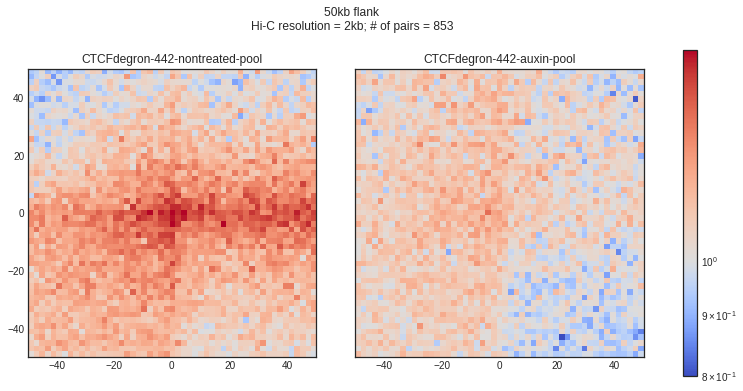

In [113]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.8,vmax=1.5,midpoint=1),
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        combined_piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'{snippet_flank//1000}kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {(upstream_pCTCF_pTSS_mask|downstream_mCTCF_mTSS_mask).sum()}')

In [114]:
combined_piles1 = combined_piles

### other combination !...

In [137]:
# here is our criteria to select a subgroup of snippets from the stack ....
downstream_mCTCF_pTSS_mask = (arm_sites["type1"]=="tss") & \
                        (arm_sites["strand1"]=="+") & \
                        (arm_sites["type2"]=="ctcf") & \
                        (arm_sites["strand2"]=="-") & \
                        (arm_sites["distance"]>50_000) & \
                        (arm_sites["distance"]<500_000)
upstream_pCTCF_mTSS_mask = (arm_sites["type1"]=="ctcf") & \
                        (arm_sites["strand1"]=="+") & \
                        (arm_sites["type2"]=="tss") & \
                        (arm_sites["strand2"]=="-") & \
                        (arm_sites["distance"]>50_000) & \
                        (arm_sites["distance"]<500_000)

# when selecting multiple conditions - it is reasonable to assume
# that these conditions are mutually exclusive
# check that the following way:
print("checking if conditions are mutually exclusive ...")
print(f"number of sites that satisfy either condition: {(upstream_pCTCF_mTSS_mask|downstream_mCTCF_pTSS_mask).sum()} ")
print(f"number of sites that satisfy condition1: {upstream_pCTCF_mTSS_mask.sum()} ")
print(f"number of sites that satisfy condition2: {downstream_mCTCF_pTSS_mask.sum()} ")
print(f"the sum {upstream_pCTCF_mTSS_mask.sum()+downstream_mCTCF_pTSS_mask.sum()} of the two latter ones is supposed to be equal to the former one")


combined_piles = {}
for cond in conditions:
    # extract only desired snippets from the stack
    # stacks are 3D arrays, with first 2 coords along the heatmap
    # and the last coord (index) is along snippets (individual interactions from BEDPE) ...
    _substack1 = stacks[cond][:,:,upstream_pCTCF_mTSS_mask]
    _substack2 = stacks[cond][:,:,downstream_mCTCF_pTSS_mask]
    # try to flip _substack2 !
    # this is going to be specific in each and every case:
    _substack2 = np.rot90(_substack2,1)[:,::-1,:]
    # flipping can be done here ...
    combined_piles[cond] = np.nanmean(
                                np.concatenate([_substack1,_substack2],axis=2),
                                axis=2
                            )

checking if conditions are mutually exclusive ...
number of sites that satisfy either condition: 1174 
number of sites that satisfy condition1: 578 
number of sites that satisfy condition2: 596 
the sum 1174 of the two latter ones is supposed to be equal to the former one


Text(0.5, 0.98, '50kb flank\nHi-C resolution = 2kb; # of pairs = 1174')

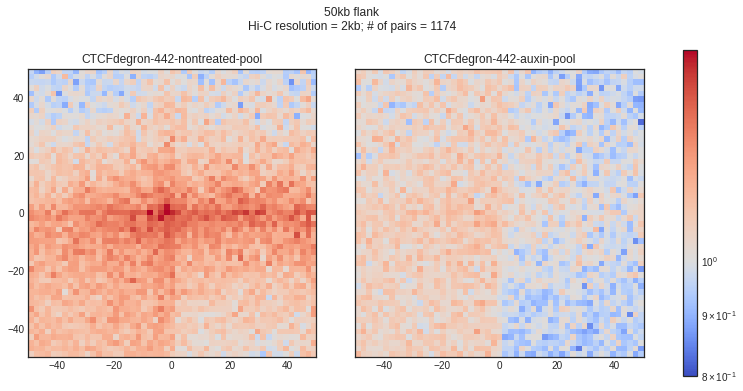

In [138]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
fig = plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    norm = MidPointLogNorm(vmin=0.8,vmax=1.5,midpoint=1),
    extent=[-snippet_flank//1000, snippet_flank//1000, -snippet_flank//1000, snippet_flank//1000],
#     cmap='RdBu_r',
    cmap='coolwarm',
    interpolation="nearest"
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        combined_piles[cond],
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'{snippet_flank//1000}kb flank\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {(upstream_pCTCF_mTSS_mask|downstream_mCTCF_pTSS_mask).sum()}')

In [154]:
# Quantifying the middle line here ...

# plt.plot(np.nanmean(combined_piles1[conditions[1]][25-2:25+3],axis=0))
# plt.plot(np.nanmean(combined_piles2[conditions[1]][25-2:25+3],axis=0))
# ax = plt.gca()
# ax.set_ylim((1.,1.5))